# transactions_hm

In [1]:
import pandas as pd
transactions = pd.read_csv("../../main/h&m_dataset/transactions_hm.csv")
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2019-11-05,3e2b60b679e62fb49516105b975560082922011dd752ec...,698328010,0.016932,2
1,2019-05-22,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,760597002,0.033881,2
2,2019-05-10,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,488561032,0.016932,2
3,2019-08-26,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,682771001,0.033881,2
4,2019-08-10,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,742400033,0.003220,1


In [2]:
transactions.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   t_dat             1048575 non-null  str    
 1   customer_id       1048575 non-null  str    
 2   article_id        1048575 non-null  int64  
 3   price             1048575 non-null  float64
 4   sales_channel_id  1048575 non-null  int64  
dtypes: float64(1), int64(2), str(2)
memory usage: 40.0 MB


In [3]:
transactions.shape

(1048575, 5)

In [4]:
na_t = transactions.isna().sum().sort_values(ascending=False) 
na_t.head(3)

t_dat          0
customer_id    0
article_id     0
dtype: int64

In [5]:
transactions["sales_channel_id"].value_counts(dropna=False)

sales_channel_id
2    729192
1    319383
Name: count, dtype: int64

In [6]:
transactions.describe().round(3)

,article_id,price,sales_channel_id
count,1.048575e+06,1048575.000,1048575.000
mean,6.746672e+08,0.028,1.695
std,1.173503e+08,0.019,0.460
min,1.087750e+08,0.000,1.000
25%,6.289790e+08,0.015,1.000
50%,7.059880e+08,0.025,2.000
75%,7.500700e+08,0.034,2.000
max,8.797400e+08,0.507,2.000


# 전처리 작업

In [7]:
trans = transactions.copy()

## 날짜 컬럼 재정의

In [8]:
trans["t_dat"] = pd.to_datetime(
    trans["t_dat"],
    errors="coerce"
)
print("변환 완료 확인")
print(trans["t_dat"].dtype)

print("\n형 변환 실패 확인")
print(trans["t_dat"].isna().sum())

변환 완료 확인
datetime64[us]

형 변환 실패 확인
0


In [9]:
# 월 파생 이거 결국엔 필요한가? 회으 후에 지우기
trans["month"] = trans["t_dat"].dt.month

# 년월 파생
trans["year_month"] = trans["t_dat"].dt.to_period("M").astype(str)

# 월일 파생
trans["month_day"] = trans["t_dat"].dt.strftime("%m-%d")

# -------------------------------------------------------------------------
# 요일 파생 큰 의미가 없을 가능성이 있기 때문에 배제
# trans["weekday"] = trans["t_dat"].dt.day_name()
# -------------------------------------------------------------------------

trans[["month", "year_month", "month_day"]].value_counts()

month  year_month  month_day
9      2019-09     09-28        12860
11     2019-11     11-29        10340
7      2019-07     07-24         8054
4      2019-04     04-06         7547
11     2019-11     11-28         6782
                                ...  
12     2019-12     12-03         1479
9      2019-09     09-21         1374
12     2019-12     12-26         1266
1      2019-01     01-01         1168
12     2019-12     12-25          895
Name: count, Length: 365, dtype: int64

### price 이상치 제거

In [10]:
print(trans['price'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

count    1.048575e+06
mean     2.777915e-02
std      1.935764e-02
min      2.372880e-04
25%      1.523729e-02
50%      2.540678e-02
75%      3.388136e-02
90%      5.083051e-02
95%      6.100000e-02
99%      1.016780e-01
max      5.067797e-01
Name: price, dtype: float64


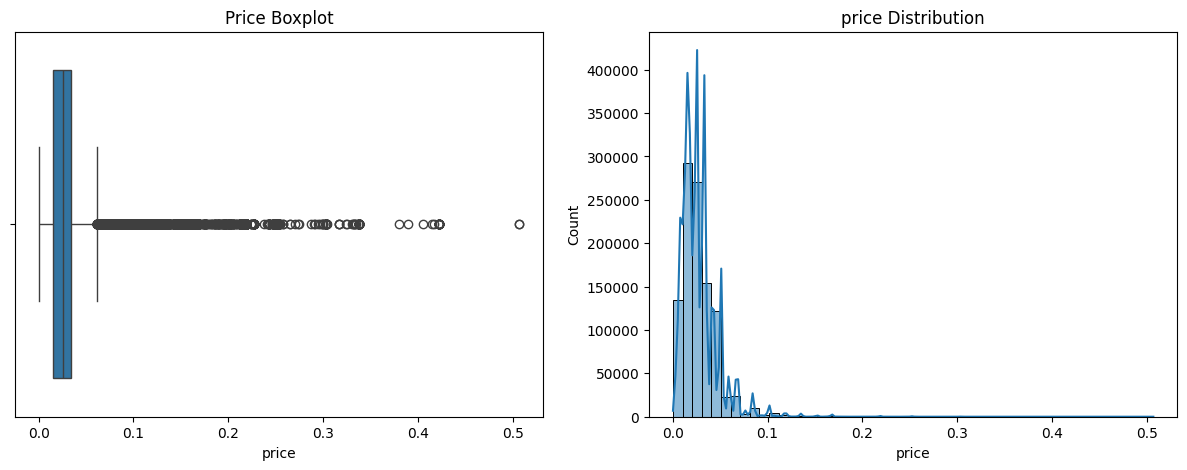

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한 화면에 두 그래프 그리기
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# 왼쪽: 박스플롯 (이상치 확인)
sns.boxplot(x=trans['price'], ax=ax[0])
ax[0].set_title('Price Boxplot')

# 오른쪽: 히스토그램 (분포 모양 확인)
sns.histplot(trans['price'], bins=50, kde=True, ax=ax[1])
ax[1].set_title('price Distribution')

plt.show()

#### 해석결과
오른쪽으로 꼬리가 긴 형태 → Price Max 값은 이상치라고 간주<br>
**Price가 0 이하인 값은 이상치라고 간주**

In [12]:
Q1 = trans['price'].quantile(0.25)
Q3 = trans['price'].quantile(0.75)
IQR = Q3 - Q1

lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

print(f"하단 기준점: {lower_fence}")
print(f"상단 기준점: {upper_fence}")
print(f"상단 기준을 넘는 데이터 수: {len(trans[trans['price'] > upper_fence])}건")

하단 기준점: -0.012728814
상단 기준점: 0.061847458
상단 기준을 넘는 데이터 수: 49868건


In [13]:
trans_clean = trans.copy()

In [14]:
trans_clean = trans_clean[trans_clean['price'] > 0]

In [15]:
trans_clean.describe().round(3)

,t_dat,article_id,price,sales_channel_id,month
count,1048575,1.048575e+06,1048575.000,1048575.000,1048575.000
mean,2019-06-27 12:01:40.730991,6.746672e+08,0.028,1.695,6.365
min,2019-01-01 00:00:00,1.087750e+08,0.000,1.000,1.000
25%,2019-04-08 00:00:00,6.289790e+08,0.015,1.000,4.000
50%,2019-06-25 00:00:00,7.059880e+08,0.025,2.000,6.000
75%,2019-09-17 00:00:00,7.500700e+08,0.034,2.000,9.000
max,2019-12-31 00:00:00,8.797400e+08,0.507,2.000,12.000
std,NaN,1.173503e+08,0.019,0.460,3.252


In [16]:
print((trans_clean['price'] == 0).sum())

0


Price 컬럼의 describe 수치를 보면 75% 지점이 0.034로 max 수치와 차이가 많이 나고, 실제 그래프를 봤을 때도 Price 0.1 이상 구간의 데이터가 거의 없는 것을 확인할 수 있다<br>
→ 0.1 이상 데이터 제거해보기

In [17]:
trans_clean = trans_clean[trans_clean['price'] < 0.1]

In [18]:
trans_clean.describe().round(3)

,t_dat,article_id,price,sales_channel_id,month
count,1037772,1.037772e+06,1037772.000,1037772.000,1037772.000
mean,2019-06-27 03:22:47.676137,6.740876e+08,0.027,1.693,6.353
min,2019-01-01 00:00:00,1.087750e+08,0.000,1.000,1.000
25%,2019-04-08 00:00:00,6.273790e+08,0.015,1.000,4.000
50%,2019-06-25 00:00:00,7.054160e+08,0.025,2.000,6.000
75%,2019-09-16 00:00:00,7.495150e+08,0.034,2.000,9.000
max,2019-12-31 00:00:00,8.797400e+08,0.100,2.000,12.000
std,NaN,1.174956e+08,0.016,0.461,3.247


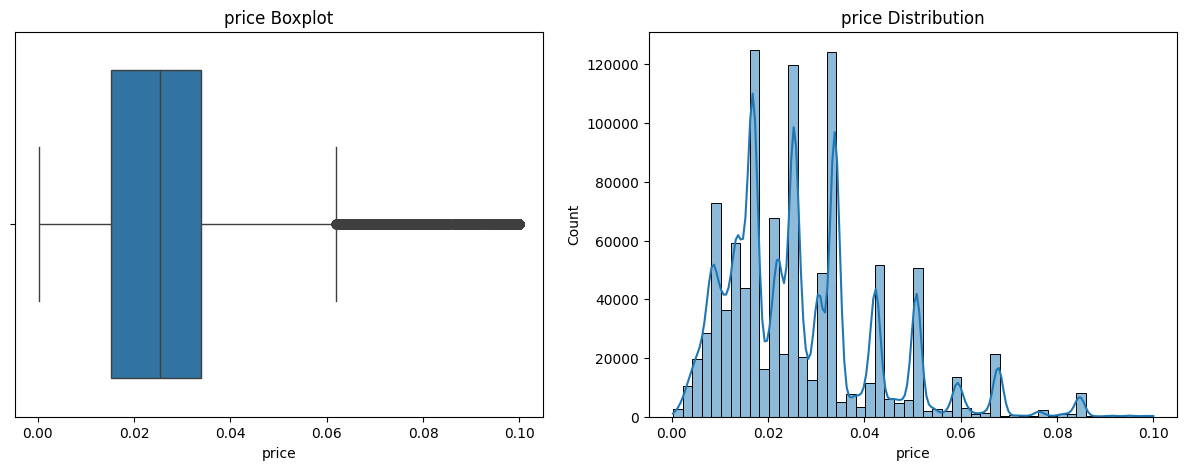

In [19]:
# 한 화면에 두 그래프 그리기
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# 왼쪽: 박스플롯 (이상치 확인)
sns.boxplot(x=trans_clean['price'], ax=ax[0])
ax[0].set_title('price Boxplot')

# 오른쪽: 히스토그램 (분포 모양 확인)
sns.histplot(trans_clean['price'], bins=50, kde=True, ax=ax[1])
ax[1].set_title('price Distribution')

plt.show()

In [20]:
trans_clean.head()

,t_dat,customer_id,article_id,price,sales_channel_id,month,year_month,month_day
0,2019-11-05,3e2b60b679e62fb49516105b975560082922011dd752ec...,698328010,0.016932,2,11,2019-11,11-05
1,2019-05-22,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,760597002,0.033881,2,5,2019-05,05-22
2,2019-05-10,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,488561032,0.016932,2,5,2019-05,05-10
3,2019-08-26,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,682771001,0.033881,2,8,2019-08,08-26
4,2019-08-10,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,742400033,0.003220,1,8,2019-08,08-10


In [21]:
trans_clean.shape

(1037772, 8)

In [22]:
trans_clean['sales_channel_id'].value_counts()

sales_channel_id
2    719317
1    318455
Name: count, dtype: int64

### price 값보정 해야하나?

### 상위 20%, 하위 20%

In [23]:
# price → revenue
trans_clean = trans_clean.rename(columns={"price": "revenue"}).copy()
trans_clean["revenue"] = trans_clean["revenue"].fillna(0)



# 고객별 총 매출을 거래 테이블에 바로 붙임
trans_clean["total_revenue"] = (
    trans_clean
    .groupby("customer_id")["revenue"]
    .transform("sum")
)

# 분위수 계산 (고객 기준이므로 중복 제거 후 계산)
q20 = (
    trans_clean[["customer_id", "total_revenue"]]
    .drop_duplicates()["total_revenue"]
    .quantile(0.2)
)

q80 = (
    trans_clean[["customer_id", "total_revenue"]]
    .drop_duplicates()["total_revenue"]
    .quantile(0.8)
)

# revenue_group 컬럼 생성
## # 그룹 라벨링 (경계 포함 규칙: <=q20 / >=q80)
trans_clean["revenue_group"] = "middle"

trans_clean.loc[
    trans_clean["total_revenue"] <= q20,
    "revenue_group"
] = "bottom_20"

trans_clean.loc[
    trans_clean["total_revenue"] >= q80,
    "revenue_group"
] = "top_20"

total_revenue = trans_clean.copy()


In [24]:
print("하위 20% 분위수:", q20)
print("상위 20% 분위수:", q80)

print("전체 거래 수:", len(total_revenue))
print("전체 고객 수:", total_revenue["customer_id"].nunique())
print(
    "상위 20% 고객 수:",
    total_revenue[total_revenue["revenue_group"] == "top_20"]["customer_id"].nunique()
)
print(
    "하위 20% 고객 수:",
    total_revenue[total_revenue["revenue_group"] == "bottom_20"]["customer_id"].nunique()
)

하위 20% 분위수: 0.016932203
상위 20% 분위수: 0.085355932
전체 거래 수: 1037772
전체 고객 수: 455812
상위 20% 고객 수: 91165
하위 20% 고객 수: 92079


## 최종확인

In [25]:
total_revenue.head()

,t_dat,customer_id,article_id,revenue,sales_channel_id,month,year_month,month_day,total_revenue,revenue_group
0,2019-11-05,3e2b60b679e62fb49516105b975560082922011dd752ec...,698328010,0.016932,2,11,2019-11,11-05,0.227186,top_20
1,2019-05-22,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,760597002,0.033881,2,5,2019-05,05-22,0.067746,middle
2,2019-05-10,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,488561032,0.016932,2,5,2019-05,05-10,0.016932,bottom_20
3,2019-08-26,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,682771001,0.033881,2,8,2019-08,08-26,0.033881,middle
4,2019-08-10,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,742400033,0.003220,1,8,2019-08,08-10,0.028627,middle


In [26]:
total_revenue.info()

<class 'pandas.DataFrame'>
Index: 1037772 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   t_dat             1037772 non-null  datetime64[us]
 1   customer_id       1037772 non-null  str           
 2   article_id        1037772 non-null  int64         
 3   revenue           1037772 non-null  float64       
 4   sales_channel_id  1037772 non-null  int64         
 5   month             1037772 non-null  int32         
 6   year_month        1037772 non-null  str           
 7   month_day         1037772 non-null  str           
 8   total_revenue     1037772 non-null  float64       
 9   revenue_group     1037772 non-null  str           
dtypes: datetime64[us](1), float64(2), int32(1), int64(2), str(4)
memory usage: 83.1 MB


In [27]:
total_revenue.shape

(1037772, 10)

In [28]:
total_revenue.isna().sum()

t_dat               0
customer_id         0
article_id          0
revenue             0
sales_channel_id    0
month               0
year_month          0
month_day           0
total_revenue       0
revenue_group       0
dtype: int64

In [29]:
total_revenue.to_csv("data/total_revenue.csv", index=False, encoding="utf-8-sig")